In [570]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
import joblib


In [571]:
# 2. Load Dataset
df = pd.read_csv('Churn_Modelling.csv')  # adjust path if needed
df.head()


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [572]:
df.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [573]:
df['Exited']

0       1
1       0
2       1
3       0
4       0
       ..
9995    0
9996    0
9997    1
9998    1
9999    0
Name: Exited, Length: 10000, dtype: int64

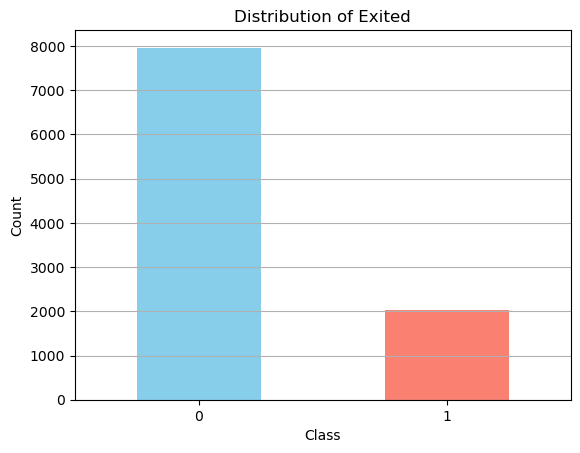

In [574]:
df['Exited'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribution of Exited')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

<Axes: >

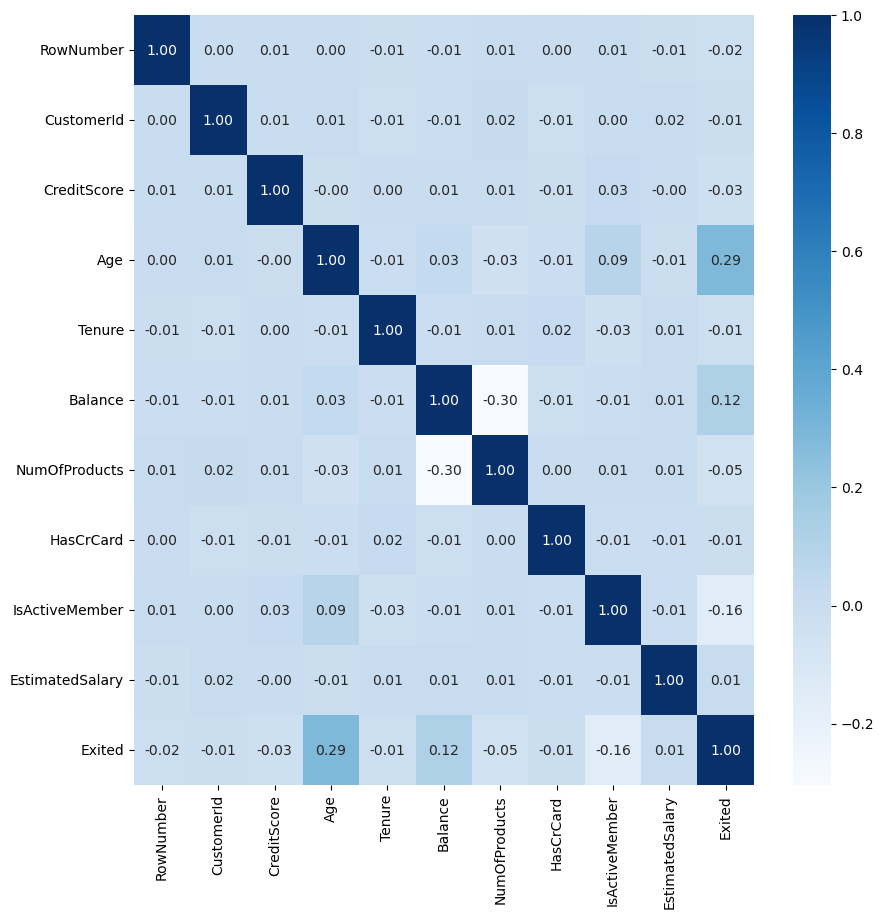

In [575]:
plt.figure(figsize=(10,10))
sns.heatmap(data=df.select_dtypes(include=['number']).corr(),label=True,cmap="Blues",annot=True,fmt='0.2f')

In [576]:
corr_matrix = df.select_dtypes(include=['number']).corr()
print(corr_matrix["Exited"].sort_values(ascending=False))


Exited             1.000000
Age                0.285323
Balance            0.118533
EstimatedSalary    0.012097
CustomerId        -0.006248
HasCrCard         -0.007138
Tenure            -0.014001
RowNumber         -0.016571
CreditScore       -0.027094
NumOfProducts     -0.047820
IsActiveMember    -0.156128
Name: Exited, dtype: float64


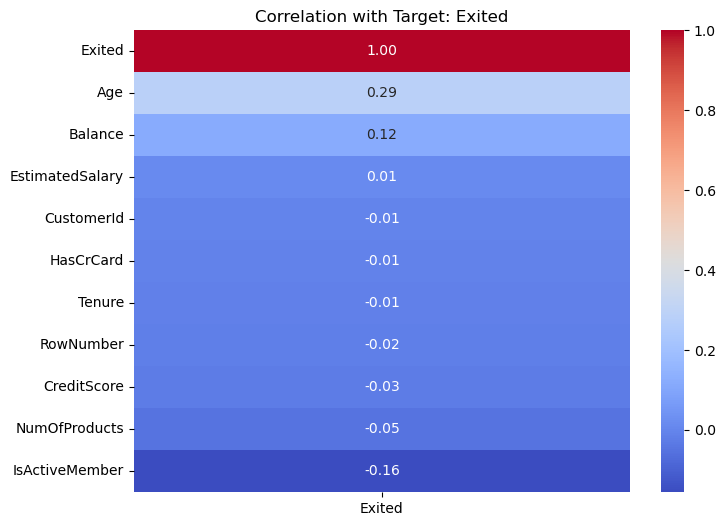

In [577]:
plt.figure(figsize=(8,6))
sns.heatmap(df.select_dtypes(include=['number']).corr()[["Exited"]].sort_values(by="Exited", ascending=False), 
            annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation with Target: Exited")
plt.show()


In [578]:
# age	+0.29	Older customers more likely to churn
# balance	+0.12	Higher balance = slightly more churn
# active_member	-0.16	Active members are less likely to churn ✅
# credit_score	-0.03	Very weak, could be noise
# estimated_salary	~0.01	No effect really

In [579]:
class_0 = df[df['Exited'] == 0]
class_1 = df[df['Exited'] == 1]

# Keep only class 0 samples that match churner-like behavior
class_0_filtered = class_0[class_0['Tenure'] < 3]

class_0_filtered.shape

(1968, 14)

In [580]:
# check null values each column

df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [581]:

# check data type with null values and features

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [582]:
df.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [583]:
# check class imbalance

df['Exited'].value_counts()

Exited
0    7963
1    2037
Name: count, dtype: int64

In [584]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [585]:
# drop non relavent columns

# df=df.drop(columns=['CustomerId'],axis=1)
df=df.drop(columns=['CustomerId','Surname','RowNumber'],axis=1)

In [586]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [587]:
# feature_engineering

df['tenure_to_age']=df['Tenure']/df['Age']

In [588]:
df['balance_to_salary']=df['Balance']/(df['EstimatedSalary']+1)

In [589]:
le=LabelEncoder()

df['Gender']=le.fit_transform(df['Gender'])
# male=1, female=0

In [590]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,tenure_to_age,balance_to_salary
0,619,France,0,42,2,0.00,1,1,1,101348.88,1,0.047619,0.000000
1,608,Spain,0,41,1,83807.86,1,0,1,112542.58,0,0.024390,0.744670
2,502,France,0,42,8,159660.80,3,1,0,113931.57,1,0.190476,1.401362
3,699,France,0,39,1,0.00,2,0,0,93826.63,0,0.025641,0.000000
4,850,Spain,0,43,2,125510.82,1,1,1,79084.10,0,0.046512,1.587035


In [591]:
# encoding country using onehotencoder 

df=pd.get_dummies(df,columns=['Geography'],drop_first=True)

In [592]:
df.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,tenure_to_age,balance_to_salary,Geography_Germany,Geography_Spain
0,619,0,42,2,0.00,1,1,1,101348.88,1,0.047619,0.000000,False,False
1,608,0,41,1,83807.86,1,0,1,112542.58,0,0.024390,0.744670,False,True
2,502,0,42,8,159660.80,3,1,0,113931.57,1,0.190476,1.401362,False,False
3,699,0,39,1,0.00,2,0,0,93826.63,0,0.025641,0.000000,False,False
4,850,0,43,2,125510.82,1,1,1,79084.10,0,0.046512,1.587035,False,True


In [593]:
# so recent version of get_dummies results in bool values so we are going with as type to convert from bool to int

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        10000 non-null  int64  
 1   Gender             10000 non-null  int32  
 2   Age                10000 non-null  int64  
 3   Tenure             10000 non-null  int64  
 4   Balance            10000 non-null  float64
 5   NumOfProducts      10000 non-null  int64  
 6   HasCrCard          10000 non-null  int64  
 7   IsActiveMember     10000 non-null  int64  
 8   EstimatedSalary    10000 non-null  float64
 9   Exited             10000 non-null  int64  
 10  tenure_to_age      10000 non-null  float64
 11  balance_to_salary  10000 non-null  float64
 12  Geography_Germany  10000 non-null  bool   
 13  Geography_Spain    10000 non-null  bool   
dtypes: bool(2), float64(4), int32(1), int64(7)
memory usage: 918.1 KB


In [594]:
df['Geography_Germany']=df['Geography_Germany'].astype('int')

df['Geography_Spain']=df['Geography_Spain'].astype('int')

In [595]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        10000 non-null  int64  
 1   Gender             10000 non-null  int32  
 2   Age                10000 non-null  int64  
 3   Tenure             10000 non-null  int64  
 4   Balance            10000 non-null  float64
 5   NumOfProducts      10000 non-null  int64  
 6   HasCrCard          10000 non-null  int64  
 7   IsActiveMember     10000 non-null  int64  
 8   EstimatedSalary    10000 non-null  float64
 9   Exited             10000 non-null  int64  
 10  tenure_to_age      10000 non-null  float64
 11  balance_to_salary  10000 non-null  float64
 12  Geography_Germany  10000 non-null  int32  
 13  Geography_Spain    10000 non-null  int32  
dtypes: float64(4), int32(3), int64(7)
memory usage: 976.7 KB


In [596]:
df['agewithnum']=df['Age']*df['NumOfProducts']
df['balancewithprod']=df['Balance']*df['NumOfProducts']
df['IsActiveMember_NuProd']=df['IsActiveMember'] * df['NumOfProducts']
df['HasCrCard_NuProd']=df['HasCrCard'] * df['NumOfProducts']
df['AgewithBalance']=df['Age']*df['Balance']

In [597]:

df['AgeGroup'] = pd.cut(df['Age'], bins=[0, 25, 50, 200], labels=['Young Adult', 'Middle-Aged', 'Senior'])

df = pd.get_dummies(df, columns=['AgeGroup'], drop_first=True)

In [598]:
# now everything is in numerical good to go for aplitting data
# so here we need to remove Estimatedsalry, HasCreditcard, Tenure, 

df=df.drop(columns=['Tenure','HasCrCard','EstimatedSalary'],axis=1)

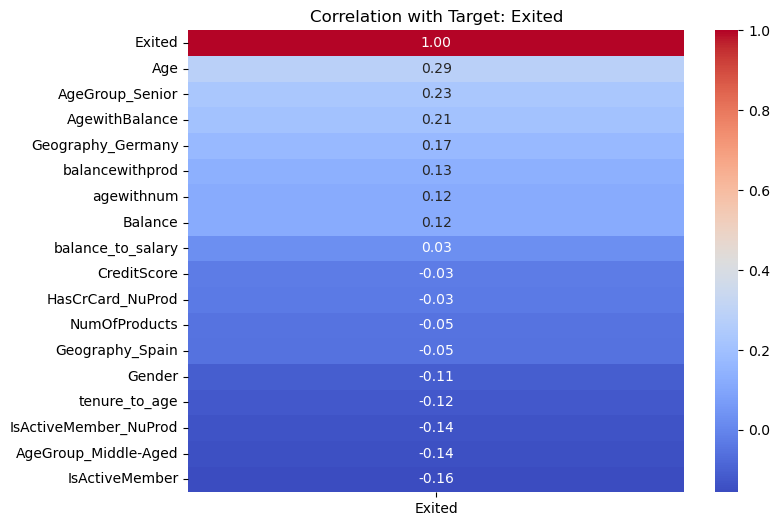

In [599]:
plt.figure(figsize=(8,6))
sns.heatmap(df.corr()[["Exited"]].sort_values(by="Exited", ascending=False), 
            annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation with Target: Exited")
plt.show()


In [600]:
# features

x=df.drop('Exited',axis=1)

In [601]:
# target

y=df['Exited']

In [602]:
# splitting dataset

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [603]:
df['Exited'].value_counts()

Exited
0    7963
1    2037
Name: count, dtype: int64

In [604]:
(df['Exited'].value_counts()[1]/len(df['Exited']))*100

20.369999999999997

In [605]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [606]:
# so here the data is imbalanced means here the churn is 20% and non churn is 80%

In [607]:
# so we need to balance ... we can use SMOTE technique: a technique used to balance the dataset

smote=SMOTE(random_state=42)


x_train_smote,y_train_smote=smote.fit_resample(x_train_scaled,y_train)


In [608]:
# need to check by building models

# LogisticRegression

lr=LogisticRegression()
lr.fit(x_train_smote,y_train_smote)

LogisticRegression()

In [609]:
# Random Forest
rf = RandomForestClassifier(n_estimators=200,random_state=2000)
rf.fit(x_train_smote, y_train_smote)


RandomForestClassifier(n_estimators=200, random_state=2000)

In [610]:

# XGBoost
xgb = XGBClassifier(random_state=42)
xgb.fit(x_train_smote, y_train_smote)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [611]:
# now evaluating models

In [612]:
y_pred_lr = lr.predict(x_test_scaled)
y_pred_rf = rf.predict(x_test_scaled)
y_pred_xgb = xgb.predict(x_test_scaled)

In [613]:



# print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_lr))
# print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))
# print("XGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))

# # ROC-AUC Score
# print(f"Logistic Regression ROC-AUC: {roc_auc_score(y_test, y_pred_lr)}")
# print(f"Random Forest ROC-AUC: {roc_auc_score(y_test, y_pred_rf)}")
# print(f"XGBoost ROC-AUC: {roc_auc_score(y_test, y_pred_xgb)}")

# # ROC Curve
# fpr_lr, tpr_lr, _ = roc_curve(y_test, lr.predict_proba(x_test_scaled)[:, 1])
# fpr_rf, tpr_rf, _ = roc_curve(y_test, rf.predict_proba(x_test_scaled)[:, 1])
# fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb.predict_proba(x_test_scaled)[:, 1])

# plt.figure(figsize=(8, 6))
# plt.plot(fpr_lr, tpr_lr, label='Logistic Regression')
# plt.plot(fpr_rf, tpr_rf, label='Random Forest')
# plt.plot(fpr_xgb, tpr_xgb, label='XGBoost')
# # plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line (no skill)
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve')
# plt.legend()
# plt.show()


In [614]:
# now will try to optimize using Hyperparameter Tuning GridSearchCV

In [615]:
from sklearn.model_selection import GridSearchCV


param={
    'n_estimators':[10,20,40,70,150,210,300],
    'max_depth':[5,10,15,None],
    'min_samples_split': [2, 5, 10],
'min_samples_leaf': [1, 2, 4]
}


In [616]:
rf_new=RandomForestClassifier(random_state=42)

In [617]:
grid_search=GridSearchCV(estimator=rf_new,param_grid=param,cv=5,scoring='f1',n_jobs=-1,verbose=1)

In [618]:
grid_search.fit(x_train_smote,y_train_smote)

Fitting 5 folds for each of 252 candidates, totalling 1260 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [10, 20, 40, 70, 150, 210, 300]},
             scoring='f1', verbose=1)

In [619]:
# best parameters found

grid_search.best_params_

{'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 300}

In [620]:
best_rf=grid_search.best_estimator_

In [621]:
print(best_rf)

RandomForestClassifier(n_estimators=300, random_state=42)


In [622]:
y_pred_best_rf=best_rf.predict(x_test_scaled)

In [623]:
# print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_lr))
# print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))
# print("XGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))
# print('classification report: ',classification_report(y_test,y_pred_best_rf))

In [624]:
# print("Logistic Regression Classification Report:\n\n", classification_report(y_test, y_pred_lr))
# print("Random Forest Classification Report:\n\n", classification_report(y_test, y_pred_rf))
# print("XGBoost Classification Report:\n\n", classification_report(y_test, y_pred_xgb))
# print('Grid_RandomForest Classification report: \n\n',classification_report(y_test,y_pred_best_rf))


# # ROC-AUC Score
# print(f"Logistic Regression ROC-AUC: {roc_auc_score(y_test, y_pred_lr)}")
# print(f"Random Forest ROC-AUC: {roc_auc_score(y_test, y_pred_rf)}")
# print(f"XGBoost ROC-AUC: {roc_auc_score(y_test, y_pred_xgb)}")
# print(f"Grid_Random ROC-AUC: {roc_auc_score(y_test, y_pred_best_rf)}")

# # ROC Curve
# fpr_lr, tpr_lr, _ = roc_curve(y_test, lr.predict_proba(x_test_scaled)[:, 1])
# fpr_rf, tpr_rf, _ = roc_curve(y_test, rf.predict_proba(x_test_scaled)[:, 1])
# fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb.predict_proba(x_test_scaled)[:, 1])
# fpr_brf, tpr_brf, _ = roc_curve(y_test, best_rf.predict_proba(x_test_scaled)[:, 1])

# plt.figure(figsize=(8, 6))
# plt.plot(fpr_lr, tpr_lr, label='Logistic Regression')
# plt.plot(fpr_rf, tpr_rf, label='Random Forest')
# plt.plot(fpr_xgb, tpr_xgb, label='XGBoost')
# plt.plot(fpr_brf, tpr_brf, label='Best Random Forest')
# # plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line (no skill)
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve')
# plt.legend()
# plt.show()


In [625]:
new_xg=XGBClassifier(random_state=42)

In [626]:
param={
        'n_estimators': [100, 200, 300, 400, 500],
        'max_depth': [3, 6, 10, 12, 15],
        'learning_rate': [0.01, 0.1, 0.001, 0.0001,0.2,0.5]
    }

In [627]:
grid_search_xg=GridSearchCV(estimator=new_xg,param_grid=param,cv=5,scoring='f1',n_jobs=-1,verbose=1)

In [628]:
grid_search_xg.fit(x_train_smote,y_train_smote)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, feature_weights=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=Non...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.001, 0.0001, 0.2, 0.5],
                         'max_depth': [3, 6, 10, 12, 15],
                         'n_estimators': [100, 200, 300, 400, 500]},
             scoring='f1', verbose=1)

In [629]:
grid_search_xg_pred=grid_search_xg.predict(x_test_scaled)

In [630]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, average_precision_score

In [631]:
# print("Accuracy:", accuracy_score(y_test, y_pred_best_rf))
# print("Precision:", precision_score(y_test, y_pred_best_rf))
# print("Recall:", recall_score(y_test, y_pred_best_rf))
# print("F1:", f1_score(y_test, y_pred_best_rf))
# print("Area under precision (AUC) Recall:", average_precision_score(y_test, y_pred_best_rf))

In [632]:
# y_probs = xgb.predict_proba(x_test_scaled)[:, 1]
# from sklearn.metrics import precision_recall_curve

# precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)

# import numpy as np

# f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-6)


In [633]:
# best_index = np.argmax(f1_scores)
# best_thresh = thresholds[best_index]
# print(f"Best threshold for XGBoost: {best_thresh:.2f}")
# y_pred_best_xg = (y_probs >= best_thresh).astype(int)



In [634]:
# print("Accuracy:", accuracy_score(y_test, y_pred_best_xg))
# print("Precision:", precision_score(y_test, y_pred_best_xg))
# print("Recall:", recall_score(y_test, y_pred_best_xg))
# print("F1:", f1_score(y_test, y_pred_best_xg))
# print("Area under precision (AUC) Recall:", average_precision_score(y_test, y_pred_best_rf))

In [635]:
# # Try manually lowering the threshold
# y_pred_lower = (y_probs >= 0.4).astype(int)

# # Recalculate precision/recall/f1
# y_pred_lower = grid_search_xg.predict_proba(x_test_scaled)[:, 1]
# from sklearn.metrics import precision_recall_curve

# precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_lower)

# import numpy as np

# f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-6)




# best_index = np.argmax(f1_scores)
# best_thresh = thresholds[best_index]
# print(f"Best threshold for gridXGBoost: {best_thresh:.2f}")
# y_pred_best_xg = (y_probs >= best_thresh).astype(int)



In [636]:

# print("Accuracy:", accuracy_score(y_test, y_pred_best_xg))
# print("Precision:", precision_score(y_test, y_pred_best_xg))
# print("Recall:", recall_score(y_test, y_pred_best_xg))
# print("F1:", f1_score(y_test, y_pred_best_xg))
# print("Area under precision (AUC) Recall:", average_precision_score(y_test, y_pred_best_rf))

Logistic Regression Classification Report:

               precision    recall  f1-score   support

           0       0.92      0.74      0.82      1607
           1       0.40      0.72      0.52       393

    accuracy                           0.73      2000
   macro avg       0.66      0.73      0.67      2000
weighted avg       0.81      0.73      0.76      2000

Random Forest Classification Report:

               precision    recall  f1-score   support

           0       0.90      0.90      0.90      1607
           1       0.60      0.60      0.60       393

    accuracy                           0.84      2000
   macro avg       0.75      0.75      0.75      2000
weighted avg       0.84      0.84      0.84      2000

XGBoost Classification Report:

               precision    recall  f1-score   support

           0       0.90      0.91      0.91      1607
           1       0.63      0.61      0.62       393

    accuracy                           0.85      2000
   macro av

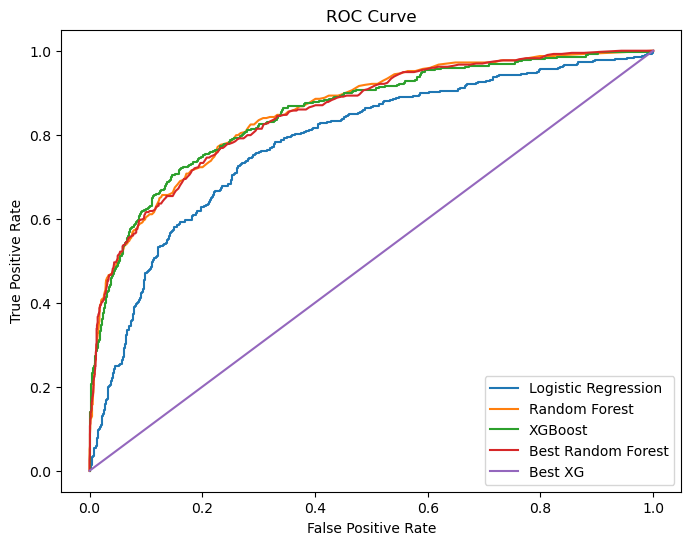

In [637]:
print("Logistic Regression Classification Report:\n\n", classification_report(y_test, y_pred_lr))
print("Random Forest Classification Report:\n\n", classification_report(y_test, y_pred_rf))
print("XGBoost Classification Report:\n\n", classification_report(y_test, y_pred_xgb))
print('Grid_RandomForest Classification report: \n\n',classification_report(y_test,y_pred_best_rf))
print('Grid Xg Classification report: \n\n',classification_report(y_test,grid_search_xg_pred))


# ROC-AUC Score
print(f"Logistic Regression ROC-AUC: {roc_auc_score(y_test, y_pred_lr)}")
print(f"Random Forest ROC-AUC: {roc_auc_score(y_test, y_pred_rf)}")
print(f"XGBoost ROC-AUC: {roc_auc_score(y_test, y_pred_xgb)}")
print(f"Grid_Random ROC-AUC: {roc_auc_score(y_test, y_pred_best_rf)}")
print(f"Grid_Xg ROC-AUC: {roc_auc_score(y_test, grid_search_xg_pred)}")

# ROC Curve
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr.predict_proba(x_test_scaled)[:, 1])
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf.predict_proba(x_test_scaled)[:, 1])
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb.predict_proba(x_test_scaled)[:, 1])
fpr_brf, tpr_brf, _ = roc_curve(y_test, best_rf.predict_proba(x_test_scaled)[:, 1])
fpr_bxg_grid, tpr_bxg_grid, _ = roc_curve(y_test, grid_search_xg.predict_proba(x_test_scaled)[:, 1])

plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression')
plt.plot(fpr_rf, tpr_rf, label='Random Forest')
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost')
plt.plot(fpr_brf, tpr_brf, label='Best Random Forest')
plt.plot(fpr_bxg_grid, fpr_bxg_grid, label='Best XG')
# plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line (no skill)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


In [638]:
# Grid_RandomForest Classification report: 

#                precision    recall  f1-score   support

#            0       0.91      0.91      0.91      1607
#            1       0.62      0.62      0.62       393

#     accuracy                           0.85      2000
#    macro avg       0.76      0.76      0.76      2000
# weighted avg       0.85      0.85      0.85      2000

# Logistic Regression ROC-AUC: 0.7287503305354596
# Random Forest ROC-AUC: 0.7517445146947753
# XGBoost ROC-AUC: 0.7589284159157376
# Grid_Random ROC-AUC: 0.7577946990821011
# Grid_Xg ROC-AUC: 0.7628006289278301



# # # best model as of now

In [639]:
# joblib.dump()